In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates

import pickle

import csv
import numpy as np
import datetime

# %matplotlib inline

from ripser import ripser, plot_dgms

# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA

import scipy.interpolate as interp

import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')


### Data preprocessing and preliminary visualization

In [4]:
df = pd.read_csv('huge_rand_10k.csv', sep=',')

In [5]:
df['purchase_date'] = pd.to_datetime(df.purchase_date)

grouped = df.groupby('card_id')

df.to_pickle('huge_processed')

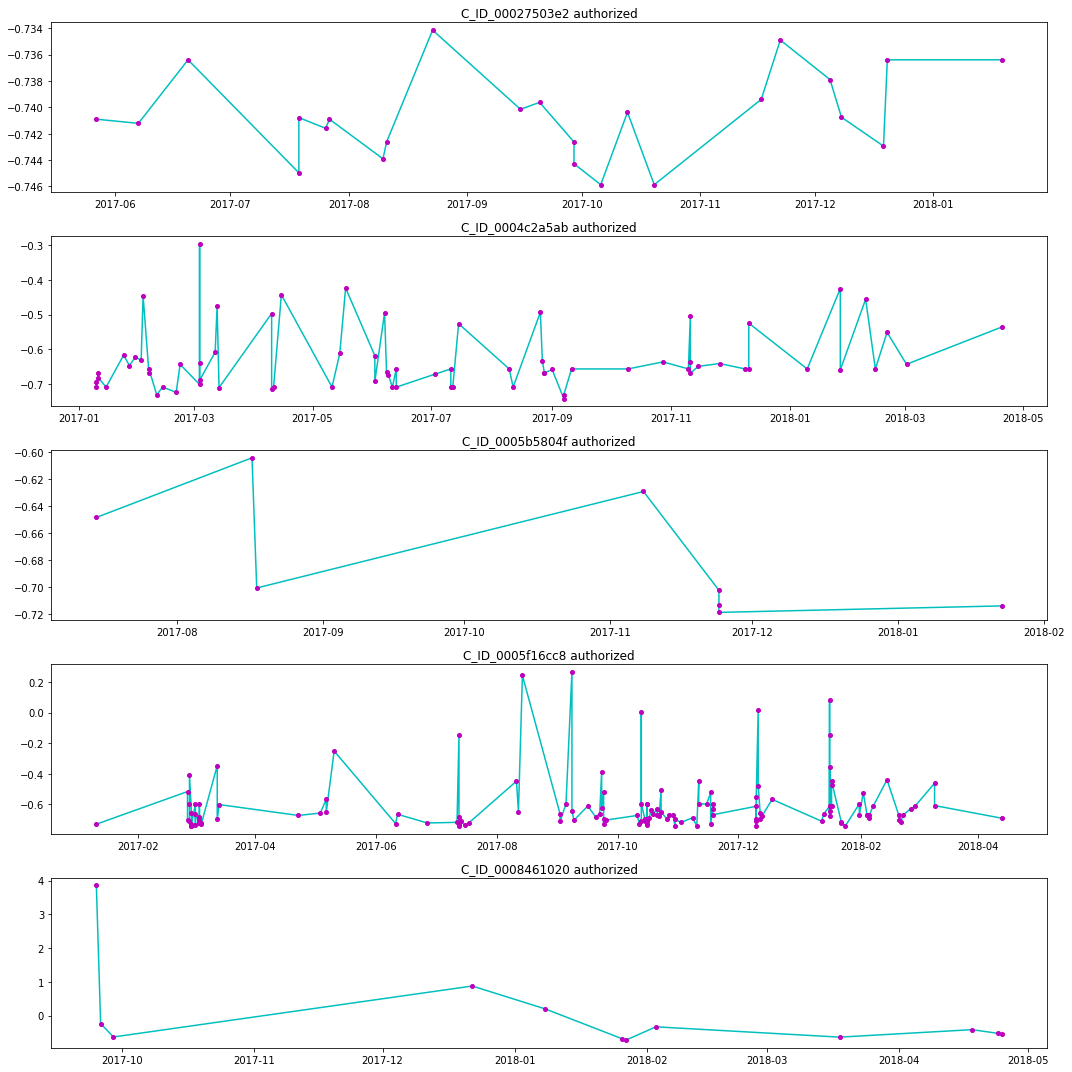

In [78]:
%matplotlib inline

n = 5
f, axs = plt.subplots(nrows=n, ncols=1, sharex=False, sharey=False, figsize=(15,3*n))

counter = 0
for name, group in grouped:
    if counter == n:
        break
#     print(name)
    group = group.sort_values(by = 'purchase_date')
    axs[counter].plot(group[group['authorized_flag']=='Y']['purchase_date'], 
                      group[group['authorized_flag']=='Y']['purchase_amount'], '-o', c='c', 
                      markerfacecolor='m', mec = 'm', markersize=4)
    axs[counter].set_title(name + ' ' + 'authorized')
#     axs[counter].grid(color='grey', linestyle='-', linewidth=0.3)
    
    counter += 1

plt.tight_layout()
# plt.subplots_adjust(top=0.92, bottom=0.7, hspace=0.25, wspace=0.35)

In [8]:
# This code generates the main database, which then will be processed
# From the grouped by card_id dataframe time serieses are processed in list
# of numpy arrays, with dates and purchase amounts, where dates are in datetime format.
# Only authorized transactions were taken into account.

counter = 0 
data = []
titles = []
for name, group in grouped:
#     if counter == 20:
#         break
    group = group.sort_values(by = 'purchase_date')
    
    titles.append(group['card_id'].iloc[0])
    data.append(np.array(group[group['authorized_flag']=='Y'][['purchase_date', 'purchase_amount']]))    
    counter +=1
    
    print(counter)
    
for i in data:
    i[:,0] = i[:,0].astype('datetime64[s]').tolist()
    

In [9]:
# Saving the data
output = open('data.pkl', 'wb')
pickle.dump(data, output)
output.close()

In [32]:
# This code generates PDFs with plots of initial time serieses
c = 0
for m in range(20):
    name = str(str(m) +'.pdf')
    pp = PdfPages(name)

    r = 16
    col = 10
    f, ax = plt.subplots(nrows=r, ncols=col, dpi = 80,sharex = False, figsize=(40,2*r))
    for i in range(r):
        for j in range(col):
            ts = data[c]
            times = ts[:,0]
            purchases = ts[:,1]
            ax[i, j].plot(times, purchases, c='m')
            ax[i, j].set_title(titles[c], fontsize=10)
            ax[i, j].yaxis.label.set_size(2)
            ax[i, j].xaxis.label.set_size(2)

            ax[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
            ax[i, j].xaxis.set_major_locator(plt.MaxNLocator(5))
            ax[i, j].yaxis.set_major_locator(plt.MaxNLocator(3))

    #         print(c)
            c +=1
    print(m)
    plt.tight_layout()
    pp.savefig(f)
    pp.close()

In [7]:
# Generating array of dates
def gen_times():
    '''
    Generate time array, starting from the first in time series, ending with the last one
    '''
    first = datetime.datetime(2017, 1, 1)
    last = datetime.datetime(2018, 4, 30)
    step = datetime.timedelta(days=1)
    result = []
    while first <= last:
        result.append(first)
        first += step
    return np.array(result)
times = gen_times()

In [8]:
def gen_whole_ts(sample, times):
    '''
    Generates time series with number of purchases from raw data
    
    sample is taken from data and has two columns: data and purchase amount
    times is time series of dates for 2 years, starting from 01.01.2017, ending at 30.04.2018
    '''
    values = np.zeros(len(times), dtype = 'int64')

    unique, counts = np.unique(sample[:,0], return_counts=True)
    uniques = dict(zip(unique, counts))
        
    for i in uniques.items():
        itemindex = np.where(times==i[0])
#         print(itemindex[0])
#         print(i[1])
        values[itemindex[0][0]] = i[1]
#     print(times)
#     whole_ts = np.hstack((times, values))
    
    return values

In [10]:
whole_data = []

for i in range(len(data)):
    whole_data.append(gen_whole_ts(data[i], times))

In [38]:
def nice_plot_two(numb, data, titles):
    '''
    This function plots _numb_th ts from dataset
    '''
    ts = data[numb]
    x = ts[:,1]
    x = x.astype('float64')
    
    tt = {'fontsize':20}
    
    ts_a = gen_whole_ts(ts, times)

    name = titles[numb]

    f, axs = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(15,6))

    axs[0].plot(ts[:, 0], x, '-o', c='c', 
                      markerfacecolor='m', mec = 'm', markersize=4)
    axs[0].set_title(name,)
    axs[0].grid(color='grey', linestyle='-', linewidth=0.3)
    
    axs[1].plot(times, ts_a, '-o', c='c', 
                      markerfacecolor='m', mec = 'm', markersize=4)
    axs[1].set_title(name + ' ' + 'whole')
    axs[1].grid(color='grey', linestyle='-', linewidth=0.3)
    
    plt.suptitle('Time series of transactions of user with card id = {}'.format(name), y=1.05)
    plt.tight_layout()

In [51]:
def nice_plot_one(numb, data, titles):
    '''
    This function plots _numb_th ts from dataset
    '''
    ts = data[numb]
    x = ts[:,1]
    x = x.astype('float64')
    
    tt = {'fontsize':20}
    
    ts_a = gen_whole_ts(ts, times)

    name = titles[numb]

    f, axs = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(13,4))

    axs.plot(ts[:, 0], x, '-o', c='c', 
                      markerfacecolor='m', mec = 'm', markersize=4)
    axs.grid(color='grey', linestyle='-', linewidth=0.3)
    
    plt.suptitle('Time series of transactions of user with card id = {}'.format(name), y=1.05, fontsize= 23)
    plt.tight_layout()

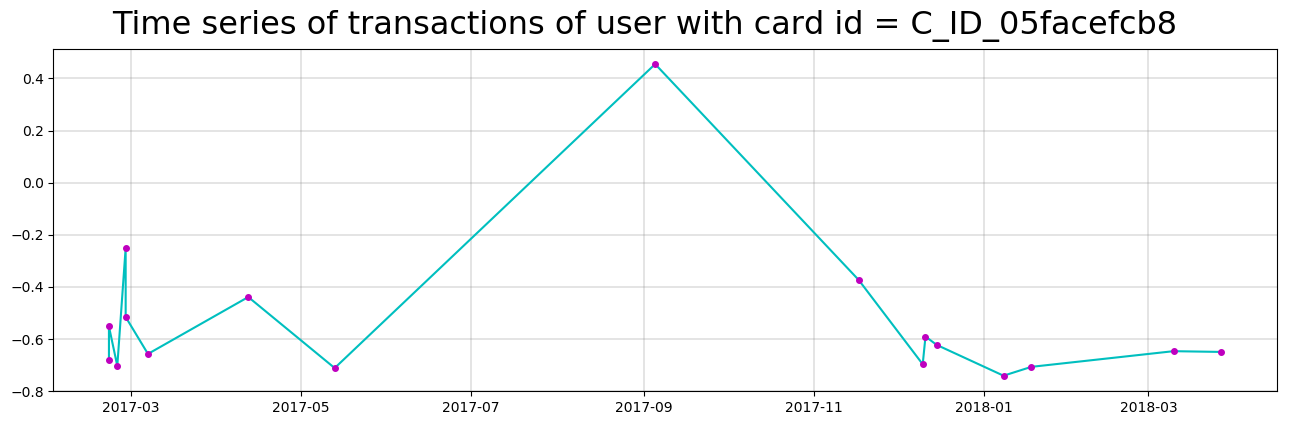

In [74]:
nice_plot_one(i, data, titles)

## Saving dataset

In [13]:
np.savetxt('whole_dataset.csv', whole_data, delimiter=",")

In [14]:
out = csv.writer(open("titles.csv","w"), delimiter=',',quoting=csv.QUOTE_ALL)
out.writerow(titles)

In [15]:
output = open('times.pkl', 'wb')
pickle.dump(times, output)
output.close()

## Loading data

In [79]:
whole_data = np.genfromtxt('whole_dataset.csv', delimiter=',')

In [80]:
pkl_file = open('data.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()

In [81]:
pkl_file = open('times.pkl', 'rb')
times = pickle.load(pkl_file)
pkl_file.close()

# with open('times.csv', 'r') as f:
#     reader = csv.reader(f)
#     times = list(reader)[0]

# for i in range(len(times)):
#     times[i] = datetime.datetime.strptime(times[i], "%Y-%m-%d %H:%M:%S")
# times = np.array(times)

In [82]:
with open('titles.csv', 'r') as f:
    reader = csv.reader(f)
    titles = list(reader)[0]

In [83]:
# This code was taken from github TDAlabs. It creates sliding windows

def getSlidingWindow(x, dim, Tau, dT):
    '''
    This function takes time series x (without time-part)
    and returns a massive X, which has sliding windows as columns
    '''
    N = len(x)
    NWindows = int(np.floor((N-dim*Tau)/dT)) # The number of windows
    if NWindows <= 0:
        print("Error: Tau too large for signal extent")
        return np.zeros((3, dim))
    X = np.zeros((NWindows, dim)) # Create a 2D array which will store all windows
    idx = np.arange(N)
    for i in range(NWindows):
        # Figure out the indices of the samples in this window
        idxx = dT*i + Tau*np.arange(dim) 
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))+2
        if end >= len(x):
            X = X[0:i, :]
            break
        # Do spline interpolation to fill in this window, and place
        # it in the resulting array
        X[i, :] = interp.spline(idx[start:end+1], x[start:end+1], idxx)
    return X

In [84]:
def sl_w_pca_2(x, dim=50, Tau=1, dT=1):
    '''
    This function takes ts and returns massive of sliding windows 
    for each of them and massive of two most important components of it
    '''
    X = getSlidingWindow(x, dim, Tau, dT)
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(X)
    return (X,Y)

In [ ]:
# This code was run on server

sliding_windows = [] #dataset with sliding windows massives for each card_id
pca_transforms = [] #dataset with pca(2) transforms of sliding windows
counter = 0
for time_series in whole_data:
    #~ if counter == 3000:
        #~ break
    w, p = sl_w_pca_2(time_series, dim=50, Tau=1, dT=1)
    sliding_windows.append(w)
    pca_transforms.append(p)
    #~ print(counter)
    counter +=1
    
output = open('sliding_windows.pkl', 'wb')
pickle.dump(sliding_windows, output)
output.close()

output = open('pca_transforms.pkl', 'wb')
pickle.dump(pca_transforms, output)
output.close()

In [85]:
pkl_file = open('sliding_windows.pkl', 'rb')
sliding_windows = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('pca_transforms.pkl', 'rb')
pca_transforms = pickle.load(pkl_file)
pkl_file.close()

In [33]:
# This code generates PDFs with graphs of PCA(2) of point clouds for time series
c = 0
for m in range(20):
    name = str(str(m) +'point_clouds' + '.pdf')
    pp = PdfPages(name)

    r = 8
    col = 8


    f, ax = plt.subplots(nrows=r, ncols=col, dpi = 80,sharex = False, figsize=(4*col,4*r))

    
    for i in range(r):
        for j in range(col):
            Y = p_t_0_3000[c]
            ax[i, j].scatter(Y[:, 0], Y[:, 1], c='c')
            ax[i, j].set_title(titles[c], fontsize=10)
            ax[i, j].yaxis.label.set_size(2)
            ax[i, j].xaxis.label.set_size(2)

#             ax[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
            ax[i, j].xaxis.set_major_locator(plt.MaxNLocator(5))
            ax[i, j].yaxis.set_major_locator(plt.MaxNLocator(3))

    #         print(c)
            c +=1

    plt.tight_layout()
    pp.savefig(f)
    pp.close()

In [44]:
#Saving each point cloud in csv, in case of problems and for possible analysis in R
for i in range(len(sliding_windows)):
    name = str(str(i)+'sw.csv')
    np.savetxt(name, sw[i], delimiter=",")

In [57]:
def barcode(PD, card_id):
    '''
    This code generates barcode diagrams of 0 and 1 dimensional homologies
    '''
    h0=len(PD[0])
    fig, [ax, bx] = plt.subplots(ncols = 2, figsize = (15, 7))
    plt.suptitle('Barcode diagram for '+ card_id, y=1, fontsize= 23)
    # unique_rows = np.unique(PD[1], axis=0)
    for i in range(h0):
        ax.plot(PD[0][i], [i, i], 'o-', c='c', linewidth = 0.5, markersize = 2)

    ax.spines['top'].set_linewidth(0.4)
    ax.spines['right'].set_linewidth(0.4)

    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    ax.tick_params(axis='y', which='both', length=0, pad=10)
    ax.tick_params(axis='x', which='both', length=3, pad=5)
    ax.set_title('0-dim', fontsize= 18)
    ax.set_yticklabels([])
    ax.set_xlabel('Radius')
    
    h1=len(PD[1])
    for i in range(h1):
        bx.plot(PD[1][i], [i, i], '-D', c='c', linewidth = 0.5, markersize = 2)

    bx.spines['top'].set_linewidth(0.4)
    bx.spines['right'].set_linewidth(0.4)

    bx.spines['left'].set_color('grey')
    bx.spines['bottom'].set_color('grey')
    bx.tick_params(axis='y', which='both', length=0, pad=10)
    bx.tick_params(axis='x', which='both', length=3, pad=5)
    bx.set_title('1-dim', fontsize= 18)
    bx.set_yticklabels([])
    bx.set_xlabel('Radius')

In [86]:
pkl_file = open('rips_filtrations.pkl', 'rb')
rips_filtrations = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('pca_transforms.pkl', 'rb')
pca_transforms = pickle.load(pkl_file)
pkl_file.close()

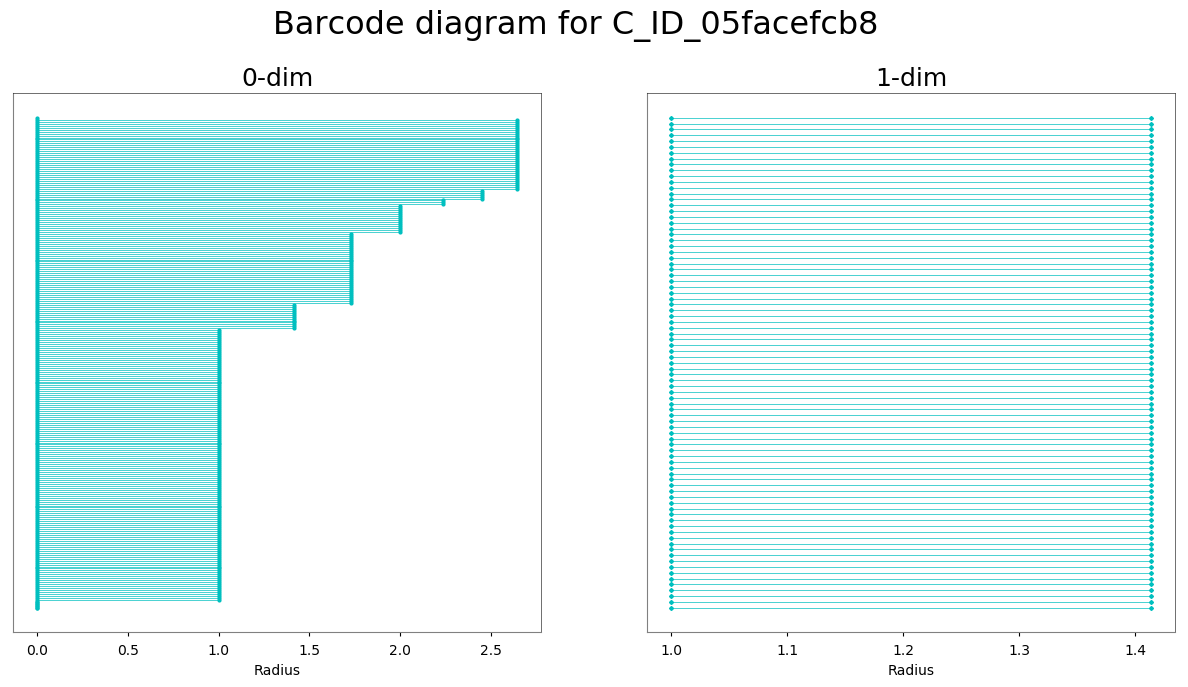

In [72]:
import random

i = random.randint(0, len(rips_filtrations))

title = titles[i]
barcode(rips_filtrations[i], title)

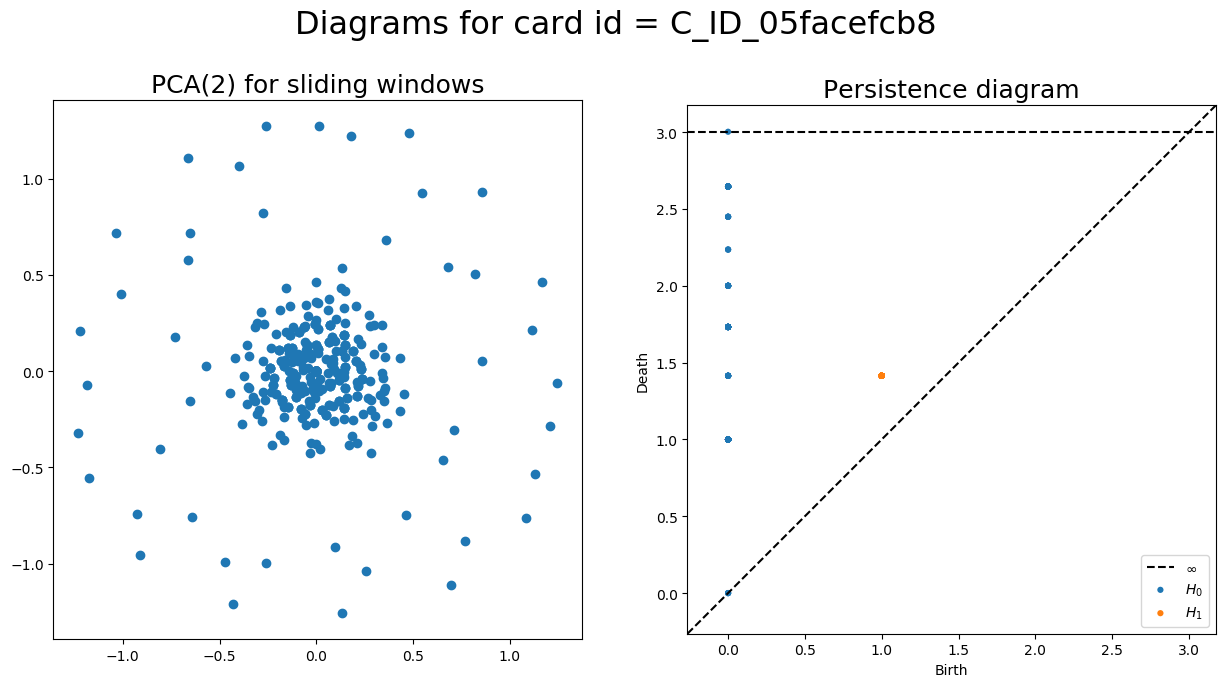

In [73]:
fig, [ax, bx] = plt.subplots(ncols = 2, figsize = (15, 7))
card_id = titles[i]
plt.suptitle('Diagrams for card id = {}'.format(card_id), y=1.01, fontsize= 23)

ax.scatter(pca_transforms[i][:, 0], pca_transforms[i][:, 1])
ax.set_title('PCA(2) for sliding windows', fontsize= 18)

bx.set_title('Persistence diagram', fontsize= 18)
plot_dgms(rips_filtrations[i], ax=bx)



In [17]:
# Generating plots of barcodes
pkl_file = open('rips_filtrations.pkl', 'rb')
rips_filtrations = pickle.load(pkl_file)
pkl_file.close()

pp = PdfPages('Barcodes.pdf')
for i in range(200):
    PD = rips_filtrations[i]
    title = titles[i]
    a = barcode(PD, title)
    print(i)
    pp.savefig(a)
pp.close()

## Feature generation

In [ ]:
# This code generates features from persistences, which will be used in k-means
pkl_file = open('rips_filtrations.pkl', 'rb')
rips_filtrations = pickle.load(pkl_file)
pkl_file.close()
print('files loaded')

number_persistences = []
number_uniques = []
max_persistences = []

birth_deathes = []
    
count = 0
for PDs in rips_filtrations:
    n = len(PDs[1])
    number_persistences.append(n)
    if PDs[1].shape[0] > 1:
        unique_rows = np.unique(PDs[1], axis=0)
        number_uniques.append(len(unique_rows))
    else:
        number_uniques.append(0)

    PD = PDs[1]
    fP = 0
    fPIdx = 0
    if PD.shape[0] > 1:
        Pers = PD[:, 1] - PD[:, 0]
        fPIdx = np.argsort(-Pers)[0]
        max_pers = Pers[fPIdx]
    else:
        max_pers = 0
    max_persistences.append(max_pers)
    row = []
    row.append(titles[count])
    for b_d in PDs[1]:
        b_d=(b_d[0], b_d[1])

        row.append(b_d)
    birth_deathes.append(row)
    print(count)
    count += 1 

output = open('number_persistences.pkl', 'wb')
pickle.dump(number_persistences, output)
output.close()

output = open('max_persistences.pkl', 'wb')
pickle.dump(max_persistences, output)
output.close()

output = open('number_uniques.pkl', 'wb')
pickle.dump(number_uniques, output)
output.close()

output = open('birth_deathes.pkl', 'wb')
pickle.dump(birth_deathes, output)
output.close()

In [91]:
pkl_file = open('number_persistences.pkl', 'rb')
number_persistences = pickle.load(pkl_file)
pkl_file.close()

In [87]:
pkl_file = open('max_persistences.pkl', 'rb')
max_persistences = pickle.load(pkl_file)
pkl_file.close()

In [88]:
pkl_file = open('birth_deathes.pkl', 'rb')
birth_deathes = pickle.load(pkl_file)
pkl_file.close()

In [89]:
pkl_file = open('number_uniques.pkl', 'rb')
number_uniques = pickle.load(pkl_file)
pkl_file.close()

## Clustering with features, generted with TDA

In [92]:
total_features = np.vstack([max_persistences, number_uniques, number_persistences]).T

In [13]:
output = open('total_features.pkl', 'wb')
pickle.dump(total_features, output)
output.close()

In [93]:
pkl_file = open('total_features.pkl', 'rb')
total_features = pickle.load(pkl_file)
pkl_file.close()

In [94]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)

labels = kmeans.fit_predict(total_features)


In [17]:
output = open('labels.pkl', 'wb')
pickle.dump(labels, output)
output.close()

In [95]:
pkl_file = open('labels.pkl', 'rb')
labels = pickle.load(pkl_file)
pkl_file.close()

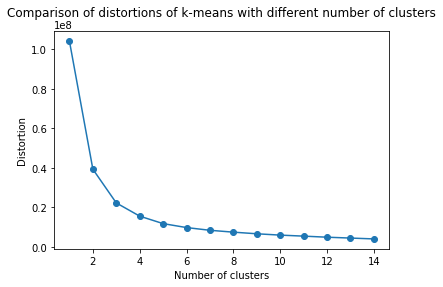

In [15]:
%matplotlib inline
distortions = []
for i in range(1, 15):
    km = KMeans(n_clusters=i, 
                random_state=0)
    km.fit(total_features)
    distortions.append(km.inertia_)
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Comparison of distortions of k-means with different number of clusters', pad = 15)

plt.show();

Text(0,0.5,'Number of unique 1D persistences')

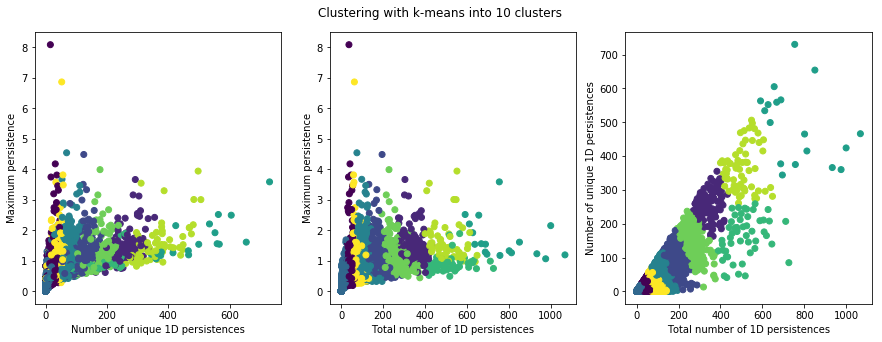

In [24]:
%matplotlib inline

fig, [ax, bx, cx] = plt.subplots(ncols = 3, figsize = (15, 5))
plt.suptitle('Clustering with k-means into 10 clusters', y=0.95)

ax.scatter(number_uniques, max_persistences, c=labels)
ax.set_xlabel('Number of unique 1D persistences')
ax.set_ylabel('Maximum persistence')

bx.scatter(number_persistences, max_persistences, c=labels)
bx.set_xlabel('Total number of 1D persistences')
bx.set_ylabel('Maximum persistence')

cx.scatter(number_persistences, number_uniques, c=labels)
cx.set_xlabel('Total number of 1D persistences')
cx.set_ylabel('Number of unique 1D persistences')

<IPython.core.display.Javascript object>


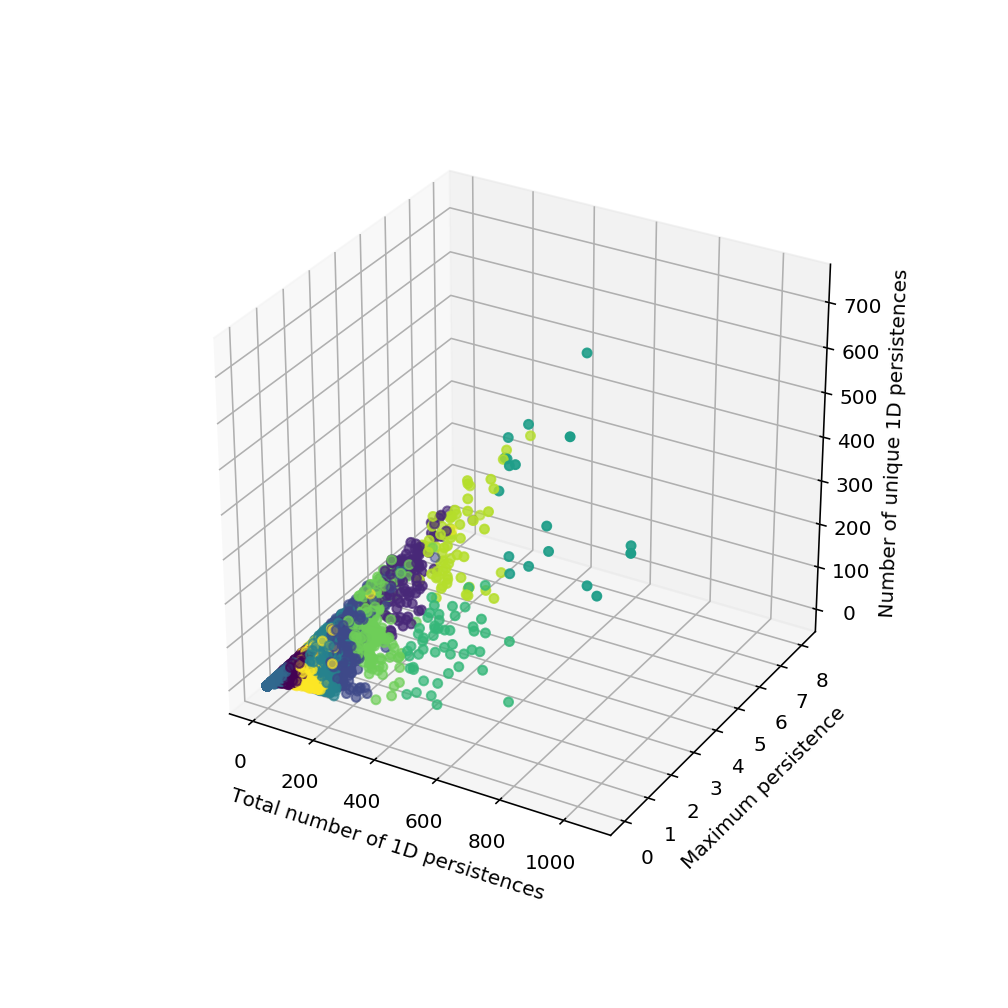

In [21]:
%matplotlib notebook

fig = plt.figure(figsize=(7, 7))
plt.title('Clustering with k-means into 10 clusters')
ax = fig.gca(projection='3d')

ax.scatter(number_persistences, max_persistences, zs = number_uniques, c=labels)

# Tweaking display region and labels
ax.set_xlabel('Total number of 1D persistences')
ax.set_ylabel('Maximum persistence')
ax.set_zlabel('Number of unique 1D persistences')

plt.show()


## K-shape clustering for comparison

In [104]:
from tslearn.clustering import KShape

X = whole_data
ks = KShape(n_clusters=10, n_init=1, verbose=False, random_state=2019)
ks.fit(X)

KShape(max_iter=100, n_clusters=10, n_init=1, random_state=2019, tol=1e-06,
    verbose=False)

In [105]:
clusters = ks.predict(X)

Text(0,0.5,'Number of unique 1D persistences')

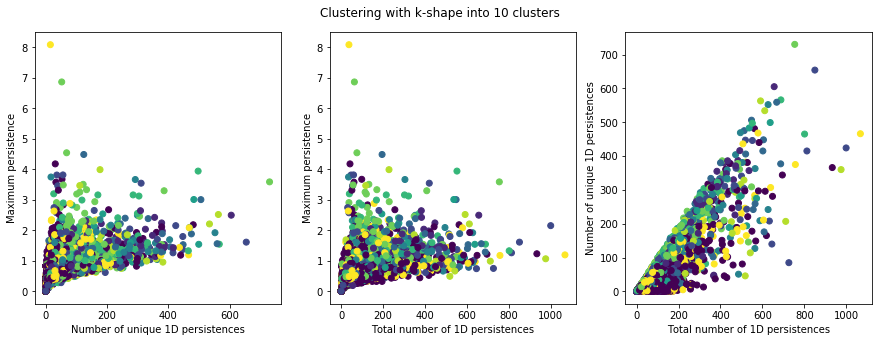

In [102]:
%matplotlib inline

fig, [ax, bx, cx] = plt.subplots(ncols = 3, figsize = (15, 5))
plt.suptitle('Clustering with k-shape into 10 clusters', y=0.95)

ax.scatter(number_uniques, max_persistences, c=clusters)
ax.set_xlabel('Number of unique 1D persistences')
ax.set_ylabel('Maximum persistence')

bx.scatter(number_persistences, max_persistences, c=clusters)
bx.set_xlabel('Total number of 1D persistences')
bx.set_ylabel('Maximum persistence')

cx.scatter(number_persistences, number_uniques, c=clusters)
cx.set_xlabel('Total number of 1D persistences')
cx.set_ylabel('Number of unique 1D persistences')

<IPython.core.display.Javascript object>


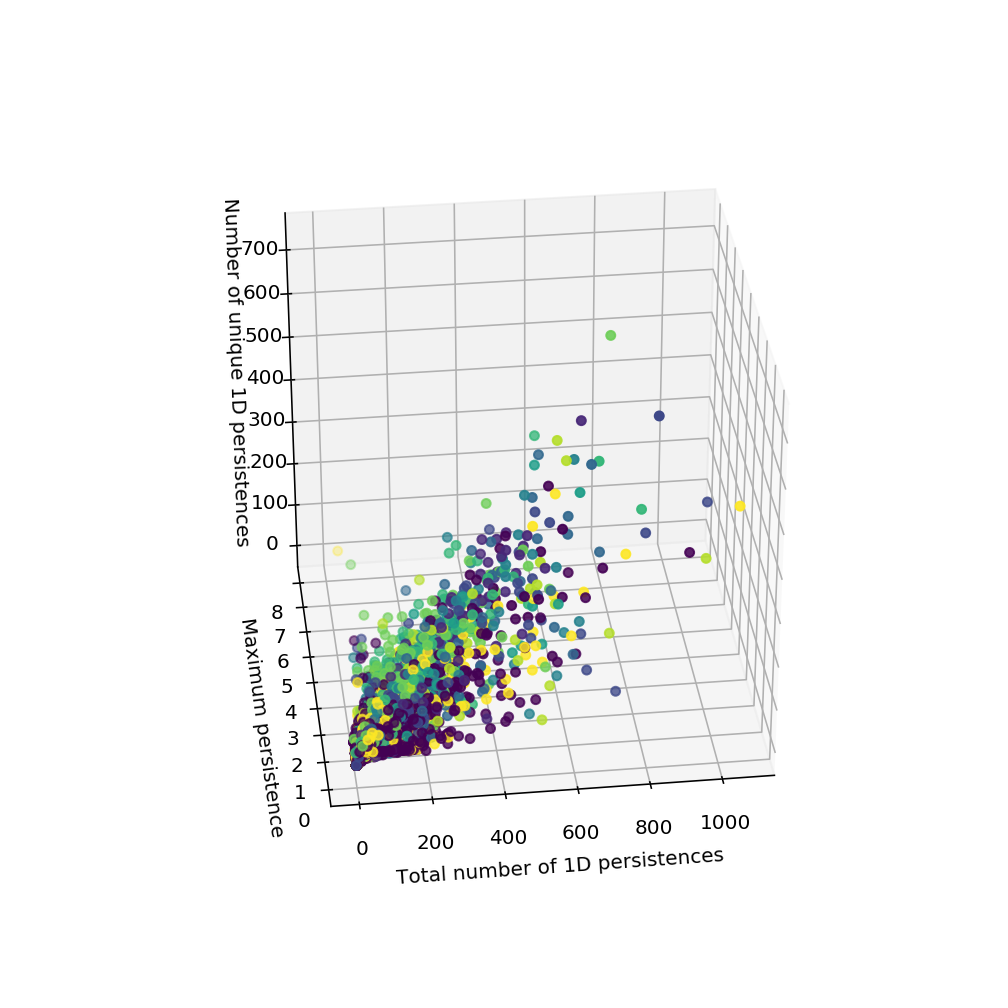

/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  """
/Users/polina/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [100]:
%matplotlib notebook

fig = plt.figure(figsize=(7, 7))
plt.title('Clustering with k-means into 10 clusters')
ax = fig.gca(projection='3d')

ax.scatter(number_persistences, max_persistences, zs = number_uniques, c=clusters)

# Tweaking display region and labels
ax.set_xlabel('Total number of 1D persistences')
ax.set_ylabel('Maximum persistence')
ax.set_zlabel('Number of unique 1D persistences')

plt.show()

## Work with train\test

In [96]:
train = pd.read_csv('train.csv',parse_dates=["first_active_month"])
test = pd.read_csv('test.csv',parse_dates=["first_active_month"])

In [97]:
ts = pd.DataFrame(whole_data, columns = times)
ts['card_id'] = titles
cols = ts.columns.tolist()
cols = cols[-1:] + cols[:-1]
ts = ts[cols]
ts.head()

,card_id,2017-01-01 00:00:00,2017-01-02 00:00:00,2017-01-03 00:00:00,2017-01-04 00:00:00,2017-01-05 00:00:00,2017-01-06 00:00:00,2017-01-07 00:00:00,2017-01-08 00:00:00,2017-01-09 00:00:00,...,2018-04-21 00:00:00,2018-04-22 00:00:00,2018-04-23 00:00:00,2018-04-24 00:00:00,2018-04-25 00:00:00,2018-04-26 00:00:00,2018-04-27 00:00:00,2018-04-28 00:00:00,2018-04-29 00:00:00,2018-04-30 00:00:00
0,C_ID_00027503e2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C_ID_0004c2a5ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C_ID_0005b5804f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C_ID_0005f16cc8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C_ID_0008461020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [98]:
test = test.drop('first_active_month', axis=1)
train = train.drop('first_active_month', axis=1)

In [99]:
features = pd.DataFrame(np.vstack([titles, labels, max_persistences, number_uniques, number_persistences]).T, 
                        columns=['card_id', 'labels', 'max_persistence', 'num_uniques', 'number_persistences'])
output = open('features.pkl', 'wb')
pickle.dump(features, output)
output.close()

In [100]:
features.head()

,card_id,labels,max_persistence,num_uniques,number_persistences
0,C_ID_00027503e2,3,0.41421353816986084,2,6
1,C_ID_0004c2a5ab,3,0.46410155296325684,8,24
2,C_ID_0005b5804f,0,0.41421353816986084,1,34
3,C_ID_0005f16cc8,3,0.9228482246398926,16,18
4,C_ID_0008461020,3,0.41421353816986084,2,23


In [101]:
labeled = pd.DataFrame(np.vstack([titles, labels]).T, 
                        columns=['card_id', 'labels'])
output = open('labeled.pkl', 'wb')
pickle.dump(labeled, output)
output.close()

In [106]:
labeled_ksh = pd.DataFrame(np.vstack([titles, clusters]).T, 
                        columns=['card_id', 'labels_ksh'])
output = open('labeled_ksh.pkl', 'wb')
pickle.dump(labeled_ksh, output)
output.close()

In [103]:
labeled.head()

,card_id,labels
0,C_ID_00027503e2,3
1,C_ID_0004c2a5ab,3
2,C_ID_0005b5804f,0
3,C_ID_0005f16cc8,3
4,C_ID_0008461020,3


In [107]:
new_train = pd.merge(train, labeled, on='card_id', how='left').dropna()


output = open('new_train.pkl', 'wb')
pickle.dump(new_train, output)
output.close()



In [108]:
new_train_alt = pd.merge(train, labeled_ksh, on='card_id', how='left').dropna()


output = open('new_train_alt.pkl', 'wb')
pickle.dump(new_train_alt, output)
output.close()



In [109]:
test.head()

,card_id,feature_1,feature_2,feature_3
0,C_ID_0ab67a22ab,3,3,1
1,C_ID_130fd0cbdd,2,3,0
2,C_ID_b709037bc5,5,1,1
3,C_ID_d27d835a9f,2,1,0
4,C_ID_2b5e3df5c2,5,1,1


In [110]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split



In [123]:
rng = np.random.RandomState(1)
regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)
MSEs = {}
# First estimate without labels
y = new_train['target']
X = new_train.drop(['target', 'card_id', 'labels'], axis = 1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=2019)
regr.fit(X_train1, y_train1)
y_pred1 = regr.predict(X_test1)
MSEs.update({'without labels':mean_squared_error(y_true=y_test1, y_pred=y_pred1)})

# Then estimate with labels from TDA based clustering
y = new_train['target']
X = new_train.drop(['target', 'card_id'], axis = 1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=2019)
regr.fit(X_train2, y_train2)
y_pred2 = regr.predict(X_test2)
MSEs.update({'with labels':mean_squared_error(y_true=y_test2, y_pred=y_pred2)})

# Then estimate with labels from k-shape clustering
y = new_train_alt['target']
X = new_train_alt.drop(['target', 'card_id'], axis = 1)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.2, random_state=2019)
regr.fit(X_train3, y_train3)
y_pred3 = regr.predict(X_test3)
MSEs.update({'with ksh labels':mean_squared_error(y_true=y_test3, y_pred=y_pred3)})


In [126]:
print('MSE of prediction with only 3 features, available initially = {:.5f}'.format(MSEs['without labels']))
print('MSE of prediction with labels from TDA based clustering = {:.5f}'.format(MSEs['with labels']))
print('MSE of prediction with labels from k-shape clustering = {:.5f}'.format(MSEs['with ksh labels']))

MSE of prediction with only 3 features, available initially = 12.96098
MSE of prediction with labels from TDA based clustering = 13.03611
MSE of prediction with labels from k-shape clustering = 13.06032
